In [1]:
import allel
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import os
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

/mnt/anaconda2/envs/pca/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/mnt/anaconda2/envs/pca/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/mnt/anaconda2/envs/pca/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/mnt/anaconda2/envs/pca/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/mnt/anaconda2/envs/pca/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/mnt/anaconda2/envs/pca/lib/python3.6/si

In [2]:
base_dir = "/mnt/uc8/intersect_dir_merged"
vcf_1 = os.path.join(base_dir, "0003.vcf")
vcf_2 = os.path.join(base_dir, "0002.vcf")
labels_1kg_f = "/home/hadoop/oda-usecase/usecase-8/integrated_call_samples_v3.20130502.ALL.panel"

In [3]:
labels_1kg = pd.read_csv(labels_1kg_f, sep="\t", header=0)
labels_1kg.set_index("sample", drop=True, inplace=True)
labels_1kg.head()

,pop,super_pop,gender
sample,,,
HG00096,GBR,EUR,male
HG00097,GBR,EUR,female
HG00099,GBR,EUR,female
HG00100,GBR,EUR,female
HG00101,GBR,EUR,male


In [4]:
def ld_prune(g1, g2, size, step, threshold=0.2, n_iter=1):
    for i in range(n_iter):
        # run for the first dataset
        loc_unlinked1 = allel.locate_unlinked(g1, size=size, step=step, threshold=threshold)
        loc_unlinked2 = allel.locate_unlinked(g2, size=size, step=step, threshold=threshold)
        loc_unlinked_both = np.logical_and(loc_unlinked1, loc_unlinked2)
        # count number of variants to be removed
        n1 = np.count_nonzero(loc_unlinked1)
        n_remove1 = g1.shape[0] - n1
        n2 = np.count_nonzero(loc_unlinked2)
        n_remove2 = g2.shape[0] - n2
        
        n_both = np.count_nonzero(loc_unlinked_both)
        n_remove_both = g1.shape[0] - n_both
        print('iteration (a)', i+1, 'retaining', n1, 'removing', n_remove1, 'variants')
        print('iteration (b)', i+1, 'retaining', n2, 'removing', n_remove2, 'variants')
        print('retaining', n_both, 'removing ', n_remove_both ,'variants')
        g1 = g1.compress(loc_unlinked_both, axis=0)
        g2 = g2.compress(loc_unlinked_both, axis=0)
    return g1, g2, loc_unlinked_both

In [5]:
def filter_genotype_arrays(vcf_1, vcf_2):
    g1 = allel.read_vcf(vcf_1)
    ga1 = allel.GenotypeArray(g1['calldata/GT'])
    print(ga1.shape)
    
    g2 = allel.read_vcf(vcf_2)
    ga2 = allel.GenotypeArray(g2['calldata/GT'])
    print(ga2.shape)
    
    ac1 = ga1.count_alleles()[:]
    # count the number of multiallelic SNPs
    print("number of multiallelic SNPs:", np.count_nonzero(ac1.max_allele() > 1))
    # count the number of biallelic singletons
    print("number of biallelic singletons:", np.count_nonzero((ac1.max_allele() == 1) & ac1.is_singleton(1)))
    # apply filtering
    flt1 = (ac1.max_allele() == 1) & (ac1[:, :2].min(axis=1) > 1)
    
    ac2 = ga2.count_alleles()[:]
    # count the number of multiallelic SNPs
    print("number of multiallelic SNPs:", np.count_nonzero(ac2.max_allele() > 1))
    # count the number of biallelic singletons
    print("number of biallelic singletons:", np.count_nonzero((ac2.max_allele() == 1) & ac2.is_singleton(1)))
    # apply filtering
    flt2 = (ac2.max_allele() == 1) & (ac2[:, :2].min(axis=1) > 1)
    
    # combine filtering of both datasets
    flt = np.logical_and(flt1, flt2)
    
    gf1 = ga1.compress(flt, axis=0)
    # fill=X means fill missing values with X
    gan1 = gf1.to_n_alt(fill=0)
    print(gan1.shape)
    gf2 = ga2.compress(flt, axis=0)
    gan2 = gf2.to_n_alt(fill=0)
    print(gan2.shape)
    
    # remove SNPs in high LD
    g1, g2, pos_list = ld_prune(gan1, gan2, size=500, step=200, threshold=0.2, n_iter=3)
    return g1, g2, pos_list

In [6]:
# filter genotype matrices
# g1, g2, pos_list = filter_genotype_arrays(vcf_1, vcf_2)
g1 = allel.read_vcf(vcf_1)
g1 = allel.GenotypeArray(g1['calldata/GT']).to_n_alt(fill=0)
print("g1 shape:", g1.shape)
g2 = allel.read_vcf(vcf_2)
g2 = allel.GenotypeArray(g2['calldata/GT']).to_n_alt(fill=0)
print("g2 shape:", g2.shape)
# print("pos_list shape:", pos_list.shape)

g1 shape: (2446, 2504)
g2 shape: (2446, 6427)


In [7]:
# turn genotype matrics into Pandas dataframes
sample_names_1kg = allel.read_vcf(vcf_1)['samples']
df_1kg = pd.DataFrame(data=g1, columns=sample_names_1kg)
# transpose since we want samples x SNPs
df_1kg = df_1kg.T
df_1kg = df_1kg.join(labels_1kg[["super_pop"]], how="inner")
display(df_1kg.head())

sample_names_atlas = allel.read_vcf(vcf_2)['samples']
df_atlas = pd.DataFrame(data=g2, columns=sample_names_atlas)
# transpose since we want samples x SNPs
df_atlas = df_atlas.T
# df_atlas.head()

,0,1,2,3,4,5,6,7,8,9,...,2437,2438,2439,2440,2441,2442,2443,2444,2445,super_pop
HG00096,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,EUR
HG00097,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,EUR
HG00099,0,0,0,0,0,1,2,0,0,0,...,1,0,0,0,0,0,0,0,0,EUR
HG00100,0,1,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,EUR
HG00101,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,EUR


In [8]:
y_1kg = df_1kg["super_pop"]
df_1kg.drop(["super_pop"], axis=1, inplace=True)

In [9]:
# split into training and testing sets
# note: we only have labels for 1000g, not AtLAs
train_1kg, test_1kg, y_train_1kg, y_test_1kg = train_test_split(df_1kg, y_1kg, test_size=0.3, random_state=42)
print("Number of 1kg train:", train_1kg.shape)
print("Number of 1kg test:", test_1kg.shape)
print("Number of 1kg train labels:", y_train_1kg.shape)
print("Number of 1kg test labels:", y_test_1kg.shape)

# note: we don't have labels for AtLAs
train_atlas, test_atlas = train_test_split(df_atlas, test_size=0.3, random_state=42)
print("Number of atlas train:", train_atlas.shape)
print("Number of atlas test:", test_atlas.shape)

Number of 1kg train: (1752, 2446)
Number of 1kg test: (752, 2446)
Number of 1kg train labels: (1752,)
Number of 1kg test labels: (752,)
Number of atlas train: (4498, 2446)
Number of atlas test: (1929, 2446)


In [10]:
# change labels from strings to integers
le = LabelEncoder()
le.fit(y_train_1kg)
y_train_1kg = le.transform(y_train_1kg)
y_test_1kg = le.transform(y_test_1kg)

In [11]:
# mean-center the data 
# train_1kg_mean =  np.mean(train_1kg, axis=0)
# train_1kg -= train_1kg_mean

# test_1kg_mean =  np.mean(test_1kg, axis=0)
# test_1kg -= test_1kg_mean

# train_atlas_mean =  np.mean(train_atlas, axis=0)
# train_atlas -= train_atlas_mean

# test_atlas_mean =  np.mean(test_atlas, axis=0)
# test_atlas -= test_atlas_mean

In [12]:
# run PCA (train on AtLAs training data)
pca = PCA(n_components=5)
pca.fit(train_atlas)
pca.mean_ = None
print(pca.mean_)

None


In [13]:
# look at variance explained
print(pca.explained_variance_ratio_)

[0.03370693 0.01224854 0.00972194 0.00462984 0.00442524]


In [14]:
# get sample loadings using SNP loadings
# 1000g sample loadings
train_1kg_loadings = pca.transform(train_1kg)
print("train_1kg_loadings shape:", train_1kg_loadings.shape)

test_1kg_loadings = pca.transform(test_1kg)
print("test_1kg_loadings shape:", test_1kg_loadings.shape)

# AtLAs sample loadings
train_atlas_loadings = pca.transform(train_atlas)
print("train_atlas_loadings shape:", train_atlas_loadings.shape)

test_atlas_loadings = pca.transform(test_atlas)
print("test_atlas_loadings shape:", test_atlas_loadings.shape)

train_1kg_loadings shape: (1752, 5)
test_1kg_loadings shape: (752, 5)
train_atlas_loadings shape: (4498, 5)
test_atlas_loadings shape: (1929, 5)


In [15]:
# write sample loadings to files
train_1kg_loadings_df = pd.DataFrame(data=train_1kg_loadings, index=train_1kg.index.values)
train_1kg_loadings_df.to_csv("1000g.train.sample.loading.txt", sep="\t", index=True, header=False)

test_1kg_loadings_df = pd.DataFrame(data=test_1kg_loadings, index=test_1kg.index.values)
test_1kg_loadings_df.to_csv("1000g.test.sample.loading.txt", sep="\t", index=True, header=False)

train_atlas_loadings_df = pd.DataFrame(data=train_atlas_loadings, index=train_atlas.index.values)
train_atlas_loadings_df.to_csv("atlas.train.sample.loading.txt", sep="\t", index=True, header=False)

test_atlas_loadings_df = pd.DataFrame(data=test_atlas_loadings, index=test_atlas.index.values)
test_atlas_loadings_df.to_csv("atlas.test.sample.loading.txt", sep="\t", index=True, header=False)

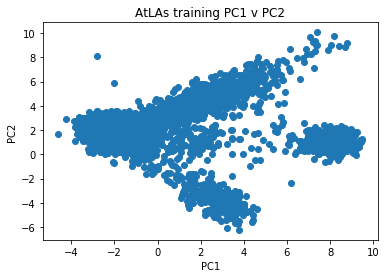

In [16]:
# plot first two PCs for AtLAs training
plt.scatter(train_atlas_loadings[:,0], train_atlas_loadings[:,1])
plt.title("AtLAs training PC1 v PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

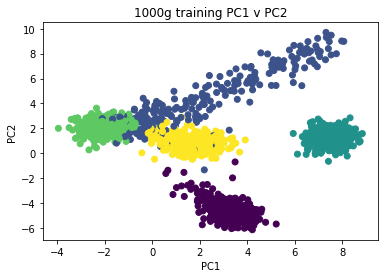

In [17]:
# plot first two PCs 
plt.scatter(train_1kg_loadings[:,0], train_1kg_loadings[:,1], c=y_train_1kg)
plt.title("1000g training PC1 v PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [19]:
# get SNP loadings
snp_loadings = pca.components_.T
print(snp_loadings.shape)
print(snp_loadings[1:10,:])

(2446, 5)
[[-0.0047203   0.00434606  0.00212998  0.00883547  0.0296192 ]
 [-0.00561461  0.00421991 -0.00135882  0.01276557  0.01355811]
 [ 0.0284662   0.08331518  0.03149895 -0.02575823  0.03875051]
 [ 0.00110166 -0.01413343  0.00628447  0.00667809 -0.00319124]
 [-0.02503471  0.01901444 -0.01234688  0.00363538  0.01024536]
 [ 0.0272081  -0.0010163  -0.01220245  0.02036456 -0.01156544]
 [ 0.00900892  0.00143661 -0.04579687 -0.01888638  0.04654488]
 [ 0.00108052  0.00187602 -0.0011813   0.00537085 -0.00234293]
 [-0.02469622  0.02399201  0.02463246 -0.0185959  -0.00081862]]


In [20]:
# get SNP positions
snp_ids = allel.read_vcf(vcf_1)['variants/ID']
snp_chrs = allel.read_vcf(vcf_1)['variants/CHROM']
snp_positions = allel.read_vcf(vcf_1)['variants/POS']

In [21]:
# write SNP loadings to file
snp_loading_df = pd.DataFrame(data=snp_loadings, columns=["X1", "X2", "X3", "X4", "X5"])
snp_loading_df["snp.rs.id"] = snp_ids
snp_loading_df["snp.chrom"] = snp_chrs
snp_loading_df["snp.pos"] = snp_positions
# reoder columns
snp_loading_df = snp_loading_df[["snp.rs.id", "snp.chrom", "snp.pos", "X1", "X2", "X3", "X4", "X5"]]
snp_loading_df.to_csv("output.loading.mat.txt", sep="\t", header=True, index=False)
snp_loading_df.head()

,snp.rs.id,snp.chrom,snp.pos,X1,X2,X3,X4,X5
0,rs145087137,1,1238583,0.002796,0.009867,0.005584,0.006102,-0.003102
1,rs11548045,1,1342394,-0.004720,0.004346,0.002130,0.008835,0.029619
2,rs75816936,1,1686081,-0.005615,0.004220,-0.001359,0.012766,0.013558
3,rs2645087,1,2288852,0.028466,0.083315,0.031499,-0.025758,0.038751
4,rs947345,1,3424388,0.001102,-0.014133,0.006284,0.006678,-0.003191


In [22]:
# train random forest model 
rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=42, n_jobs=-1)
rf.fit(train_1kg_loadings, y_train_1kg)

predictions_1kg_train = rf.predict(train_1kg_loadings)
cm = confusion_matrix(y_train_1kg, predictions_1kg_train)
print(cm)
print("accuracy:", rf.score(train_1kg_loadings, y_train_1kg))

[[461   0   0   0   0]
 [  0 243   0   0   0]
 [  0   0 342   0   0]
 [  0   0   0 362   0]
 [  0   0   0   0 344]]
accuracy: 1.0


In [23]:
# check prediction results on 1000g test set
predictions_1kg_test = rf.predict(test_1kg_loadings)
cm = confusion_matrix(y_test_1kg, predictions_1kg_test)
print(cm)
print("accuracy:", rf.score(test_1kg_loadings, y_test_1kg))

[[197   3   0   0   0]
 [  1  95   0   6   2]
 [  0   0 162   0   0]
 [  0   2   0 139   0]
 [  0   1   0   1 143]]
accuracy: 0.9787234042553191


In [24]:
# check prediction results on AtLAs train set
predictions_atlas_train = rf.predict(train_atlas_loadings)
pred_train_counts = np.bincount(predictions_atlas_train)
for cls, cnt in zip(np.nonzero(pred_train_counts)[0], pred_train_counts[np.nonzero(pred_train_counts)[0]]):
    print("class:", le.inverse_transform(cls), "count:", cnt, "\tfreq:", cnt/len(predictions_atlas_train))

class: AFR count: 288 	freq: 0.06402845709204091
class: AMR count: 906 	freq: 0.20142285460204534
class: EAS count: 411 	freq: 0.09137394397510004
class: EUR count: 2743 	freq: 0.6098265895953757
class: SAS count: 150 	freq: 0.03334815473543797


In [25]:
# check prediction results on AtLAs test set
predictions_atlas_test = rf.predict(test_atlas_loadings)
pred_test_counts = np.bincount(predictions_atlas_test)
for cls, cnt in zip(np.nonzero(pred_test_counts)[0], pred_test_counts[np.nonzero(pred_test_counts)[0]]):
    print("class:", le.inverse_transform(cls), "count:", cnt, "\tfreq:", cnt/len(predictions_atlas_test))

class: AFR count: 106 	freq: 0.054950751684810784
class: AMR count: 364 	freq: 0.1886988076723691
class: EAS count: 187 	freq: 0.09694142042509073
class: EUR count: 1204 	freq: 0.6241575946086055
class: SAS count: 68 	freq: 0.0352514256091239


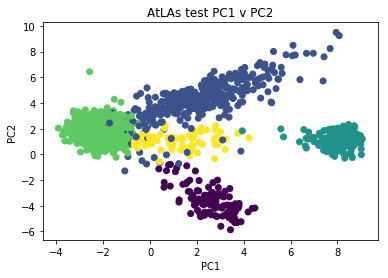

In [26]:
# plot first two PCs 
plt.scatter(test_atlas_loadings[:,0], test_atlas_loadings[:,1], c=predictions_atlas_test)
plt.title("AtLAs test PC1 v PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()